# Set up environment

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# Test if GPU is available
# Note that CUDA below 12.1 can have bugs
import torch
print(torch.cuda.is_available())
# print(torch.cuda.get_device_name(0))
print(torch.version.cuda)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

True
12.1


In [3]:
#%% import libraries
import os
from collections import defaultdict
import sys

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import copy
import numpy as np
import numpy.random
from numpy.fft import fft as fft
from numpy.fft import ifft as ifft
import pickle
from sklearn.linear_model import PoissonRegressor
from sklearn.model_selection import KFold
from sklearn.manifold import TSNE
import scipy.stats
from scipy.stats import wilcoxon, chi2
import scipy.interpolate 
import scipy.signal
from scipy import linalg
from scipy.special import rel_entr
from tqdm import tqdm
import pandas as pd
import joblib
import logging

import statsmodels.api as sm
import statsmodels.genmod.generalized_linear_model as smm

import torch
from torch.autograd import Variable
from torch.nn import functional as F
import torch.nn as nn
import torch.optim as optim

In [4]:
# import my code
import utility_functions as utils
import GLM
from DataLoader import Allen_dataset, Allen_dataloader_multi_session, Simple_dataloader_from_spikes
from model_trainer import Trainer

utils.set_seed(0)

/home/qix/anaconda3/envs/allen/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load data

In [11]:
# Load GLM neuron dataset
file_name = '/home/qix/user_data/EIF_simulation_dataset/synthetic_data_GLM.npz'
data = np.load(file_name)
spikes = data['spikes'][:,:,:]
nneuron = spikes.shape[1]//2
synthetic_GLM_dataloader = Simple_dataloader_from_spikes(
    [spikes[:,:nneuron,:], spikes[:,nneuron:,:]],
    npadding=50,
    train_ratio=0.7,
    val_ratio=0.1,
    batch_size=64,
    verbose=True
)

# Load EIF neuron dataset
file_name = f'/home/qix/user_data/EIF_simulation_dataset/synthetic_data_EIF_connTrue.npz'
data = np.load(file_name, allow_pickle=True)
spikes = data['spikes'][:,:,:]
nneuron = spikes.shape[1]//2
synthetic_EIF_dataloader = Simple_dataloader_from_spikes(
    [spikes[:,:nneuron,:], spikes[:,nneuron:,:]],
    npadding=50,
    train_ratio=0.7,
    val_ratio=0.1,
    batch_size=64,
    verbose=True
)

# Load real dataset
if sys.platform == 'linux':
    data_path = '/home/qix/user_data/allen_spike_trains/single_sessions.joblib'
else:
    data_path = 'D:/ecephys_cache_dir/single_sessions.joblib'
real_dataloader = joblib.load(data_path)

In [12]:
spikes = np.zeros((250, 352, 132*64))
trial_idx = 0
for batch in real_dataloader.train_loader:
    spikes[:, :, trial_idx:trial_idx+batch['spike_trains'].shape[2]] = batch['spike_trains']
    trial_idx += batch['spike_trains'].shape[2]
acc_nneuron = [0] + list(np.cumsum(real_dataloader.sessions[757216464].nneuron_list))

real_dataloader_fast = Simple_dataloader_from_spikes(
    [spikes[:,acc_nneuron[i]:acc_nneuron[i+1],:] for i in range(len(acc_nneuron)-1)],
    npadding=50,
    train_ratio=0.7,
    val_ratio=0.1,
    batch_size=64,
    verbose=True
)

/home/qix/anaconda3/envs/allen/lib/python3.9/site-packages/allensdk/brain_observatory/ecephys/ecephys_session.py:1371: UserWarning: Session includes invalid time intervals that could be accessed with the attribute 'invalid_times',Spikes within these intervals are invalid and may need to be excluded from the analysis.
  warnings.warn("Session includes invalid time intervals that could "


# Ablation experiments

In [ ]:
# Settings for all ablation experiments
verbose = False
# datasets = [synthetic_GLM_dataloader, synthetic_EIF_dataloader]
datasets = [synthetic_GLM_dataloader, synthetic_EIF_dataloader, real_dataloader_fast]
nrep = 5
ckp_path = '/home/qix/user_data/VAETransformer_checkpoint_ablation'

params_set = {}
params_set[0] = {
    # B-spline basis
    'num_B_spline_basis': 10,
    # Transformer VAE's settings
    'downsample_factor': 10,
    'transformer_num_layers': 2,
    'transformer_d_model': 128,
    'transformer_dim_feedforward': 512,
    'transformer_vae_output_dim': 8,
    'transformer_dropout': 0.0,
    'transformer_nhead': 1,
    'stimulus_nfactor': 2,
    'stimulus_decoder_inter_dim_factor': 2,
    'beta': 1.0,
    'use_area_specific_decoder': True,
    'use_area_specific_encoder': True,
    'use_cls': False,
    # Coupling's settings
    'coupling_basis_peaks_max': 7,
    'coupling_basis_num': 3,
    'coupling_nsubspace': 1,
    'use_self_coupling': True,
    # Coupling strength latent's settings
    'K_sigma2': 1.0,
    'K_tau': 100,
    'coupling_strength_nlatent': 1,
    # Self-history's settings
    'self_history_basis_peaks_max': 2,
    'self_history_basis_num': 3,
    'self_history_basis_nonlinear': 0.7,
    # Penalty settings
    'penalty_smoothing_spline': 1e3,
    'penalty_coupling_subgroup': 1e-5,
    'penalty_diff_loading': None,
    'penalty_loading_similarity': None,
    # Training settings
    'batch_size': 64,
    'sample_latent': False,
    'lr': 1e-3,
    'epoch_warm_up': 0,
    'epoch_patience': 3,
    'epoch_max': 200,
    'tol': 1e-5,
    'weight_decay': 0,
    'lr_transformer': 1e-4,
    'lr_sti': 1e-2,
    'lr_cp': 1e-2,
    'lr_self_history': 1e-2,
}

params_set[1] = {
    # B-spline basis
    'num_B_spline_basis': 20,
    # Transformer VAE's settings
    'downsample_factor': 10,
    'transformer_num_layers': 2,
    'transformer_d_model': 128,
    'transformer_dim_feedforward': 512,
    'transformer_vae_output_dim': 16,
    'transformer_dropout': 0.0,
    'transformer_nhead': 1,
    'stimulus_nfactor': 1,
    'stimulus_decoder_inter_dim_factor': 2,
    'beta': 1.0,
    'use_area_specific_decoder': True,
    'use_area_specific_encoder': True,
    'use_cls': False,
    # Coupling's settings
    'coupling_basis_peaks_max': 5,
    'coupling_basis_num': 3,
    'coupling_nsubspace': 1,
    'use_self_coupling': True,
    # Coupling strength latent's settings
    'K_sigma2': 1.0,
    'K_tau': 100,
    'coupling_strength_nlatent': 1,
    # Self-history's settings
    'self_history_basis_peaks_max': 1.5,
    'self_history_basis_num': 3,
    'self_history_basis_nonlinear': 1,
    # Penalty settings
    'penalty_smoothing_spline': 1e3,
    'penalty_coupling_subgroup': 1e-5,
    'penalty_diff_loading': None,
    'penalty_loading_similarity': None,
    # Training settings
    'batch_size': 64,
    'sample_latent': False,
    'lr': 1e-3,
    'epoch_warm_up': 0,
    'epoch_patience': 3,
    'epoch_max': 200,
    'tol': 1e-5,
    'weight_decay': 0,
    'lr_transformer': 1e-4,
    'lr_sti': 1e-2,
    'lr_cp': 1e-2,
    'lr_self_history': 1e-2,
}

params_set[2] = {
    # B-spline basis
    'num_B_spline_basis': 10,
    # Transformer VAE's settings
    'downsample_factor': 10,
    'transformer_num_layers': 2,
    'transformer_d_model': 128,
    'transformer_dim_feedforward': 512,
    'transformer_vae_output_dim': 12,
    'transformer_dropout': 0.0,
    'transformer_nhead': 1,
    'stimulus_nfactor': 2,
    'stimulus_decoder_inter_dim_factor': 2,
    'beta': 1.0,
    'use_area_specific_decoder': True,
    'use_area_specific_encoder': True,
    'use_cls': False,
    # Coupling's settings
    'coupling_basis_peaks_max': 7,
    'coupling_basis_num': 3,
    'coupling_nsubspace': 1,
    'use_self_coupling': True,
    # Coupling strength latent's settings
    'K_sigma2': 1.0,
    'K_tau': 100,
    'coupling_strength_nlatent': 1,
    # Self-history's settings
    'self_history_basis_peaks_max': 1.5,
    'self_history_basis_num': 3,
    'self_history_basis_nonlinear': 1,
    # Penalty settings
    'penalty_smoothing_spline': 1e3,
    'penalty_coupling_subgroup': 1e-5,
    'penalty_diff_loading': None,
    'penalty_loading_similarity': None,
    # Training settings
    'batch_size': 64,
    'sample_latent': False,
    'lr': 1e-3,
    'epoch_warm_up': 0,
    'epoch_patience': 3,
    'epoch_max': 50,
    'tol': 1e-5,
    'weight_decay': 0,
    'lr_transformer': 1e-4,
    'lr_sti': 1e-2,
    'lr_cp': 1e-2,
    'lr_self_history': 1e-2,
}

In [ ]:
# Full model
results_ablation = np.zeros((len(datasets), nrep))

for idata, data_to_use in enumerate(datasets):
    for irep in range(nrep):

        trainer = Trainer(data_to_use, ckp_path, params_set[idata])
        
        # First step: train the model with a trial-invariant stimulus effect
        trainer.train(
            include_stimulus=True,
            include_coupling=False,
            include_self_history=False,
            fix_stimulus=True,
            fix_latents=True,
            verbose=verbose,
        )
        # Second step: train the model with a trial-varying stimulus effect
        # trainer.make_optimizer(frozen_params=['sti_readout'])
        trainer.make_optimizer(frozen_params=['sti_inhomo', ]) # We are fixing the trial-invariant stimulus effect
        trainer.train(
            include_stimulus=True,
            include_coupling=False,
            include_self_history=False,
            fix_stimulus=False,
            fix_latents=True,
            verbose=verbose,
        )

        trainer.make_optimizer(frozen_params=['transformer_encoder', 'to_latent', 'token_converter'])
        # trainer.make_optimizer(frozen_params=[])
        trainer.train(
            include_stimulus=True,
            include_coupling=True,
            include_self_history=False,
            fix_stimulus=False,
            fix_latents=True,
            verbose=verbose,
        )

        # trainer.make_optimizer(frozen_params=['transformer_encoder', 'to_latent', 'token_converter'])
        trainer.make_optimizer(frozen_params=['transformer_encoder', 'to_latent', 'token_converter',
            'sti_readout', 'sti_decoder', 'sti_inhomo', 'cp_latents_readout', 'cp_time_varying_coef_offset', 
            'cp_beta_coupling', 'cp_weight_sending', 'cp_weight_receiving'])
        # trainer.make_optimizer(frozen_params=[])
        test_loss = trainer.train(
            include_stimulus=True,
            include_coupling=True,
            include_self_history=True,
            fix_stimulus=False,
            fix_latents=True,
            verbose=verbose,
        )

        results_ablation[idata, irep] = test_loss

np.save('/home/qix/user_data/EIF_simulation_dataset/results_ablation_full_model.npy', results_ablation)

Total sessions: 1, Batch size: 64, Train set size: 132, Val set size: 20, Test set size: 39


/home/qix/anaconda3/envs/allen/lib/python3.9/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Model initialized. Training on cuda


  0%|          | 0/50 [00:13<?, ?it/s]


KeyboardInterrupt: 

In [95]:
# Without Transformer encoder model
results_ablation = np.zeros((len(datasets), nrep))

for idata, data_to_use in enumerate(datasets):
    for irep in range(nrep):

        trainer = Trainer(data_to_use, ckp_path, params_set[idata])
        
        # First step: train the model with a trial-invariant stimulus effect
        trainer.train(
            include_stimulus=True,
            include_coupling=False,
            include_self_history=False,
            fix_stimulus=True,
            fix_latents=True,
            verbose=verbose,
        )

        trainer.make_optimizer(frozen_params=['transformer_encoder', 'to_latent', 'token_converter'])
        # trainer.make_optimizer(frozen_params=[])
        trainer.train(
            include_stimulus=True,
            include_coupling=True,
            include_self_history=False,
            fix_stimulus=False,
            fix_latents=True,
            verbose=verbose,
        )

        # trainer.make_optimizer(frozen_params=['transformer_encoder', 'to_latent', 'token_converter'])
        trainer.make_optimizer(frozen_params=['transformer_encoder', 'to_latent', 'token_converter',
            'sti_readout', 'sti_decoder', 'sti_inhomo', 'cp_latents_readout', 'cp_time_varying_coef_offset', 
            'cp_beta_coupling', 'cp_weight_sending', 'cp_weight_receiving'])
        # trainer.make_optimizer(frozen_params=[])
        test_loss = trainer.train(
            include_stimulus=True,
            include_coupling=True,
            include_self_history=True,
            fix_stimulus=False,
            fix_latents=True,
            verbose=verbose,
        )

        results_ablation[idata, irep] = test_loss

np.save('/home/qix/user_data/EIF_simulation_dataset/results_ablation_wo_encoder.npy', results_ablation)

Model initialized. Training on cuda


 30%|███       | 60/200 [00:07<00:17,  8.08it/s]


Model initialized. Training on cuda


 28%|██▊       | 56/200 [00:06<00:16,  8.57it/s]


Model initialized. Training on cuda


 29%|██▉       | 58/200 [00:06<00:16,  8.49it/s]


Model initialized. Training on cuda


 29%|██▉       | 58/200 [00:06<00:15,  8.94it/s]


Model initialized. Training on cuda


 30%|██▉       | 59/200 [00:07<00:17,  8.22it/s]


Model initialized. Training on cuda


 28%|██▊       | 57/200 [00:07<00:18,  7.84it/s]


Model initialized. Training on cuda


 28%|██▊       | 57/200 [00:06<00:15,  9.19it/s]


Model initialized. Training on cuda


 28%|██▊       | 55/200 [00:06<00:16,  8.75it/s]


Model initialized. Training on cuda


 28%|██▊       | 56/200 [00:07<00:18,  7.74it/s]


Model initialized. Training on cuda


 28%|██▊       | 55/200 [00:06<00:17,  8.46it/s]


Model initialized. Training on cuda


 32%|███▏      | 16/50 [00:21<00:46,  1.36s/it]


Model initialized. Training on cuda


 32%|███▏      | 16/50 [00:21<00:45,  1.35s/it]


Model initialized. Training on cuda


 32%|███▏      | 16/50 [00:21<00:46,  1.36s/it]


Model initialized. Training on cuda


 32%|███▏      | 16/50 [00:21<00:45,  1.33s/it]


Model initialized. Training on cuda


 26%|██▌       | 13/50 [00:17<00:50,  1.36s/it]


In [96]:
# Without coupling
results_ablation = np.zeros((len(datasets), nrep))

for idata, data_to_use in enumerate(datasets):
    for irep in range(nrep):

        trainer = Trainer(data_to_use, ckp_path, params_set[idata])
        
        # First step: train the model with a trial-invariant stimulus effect
        trainer.train(
            include_stimulus=True,
            include_coupling=False,
            include_self_history=False,
            fix_stimulus=True,
            fix_latents=True,
            verbose=verbose,
        )
        # Second step: train the model with a trial-varying stimulus effect
        # trainer.make_optimizer(frozen_params=['sti_readout'])
        trainer.make_optimizer(frozen_params=['sti_inhomo', ]) # We are fixing the trial-invariant stimulus effect
        trainer.train(
            include_stimulus=True,
            include_coupling=False,
            include_self_history=False,
            fix_stimulus=False,
            fix_latents=True,
            verbose=verbose,
        )

        # trainer.make_optimizer(frozen_params=['transformer_encoder', 'to_latent', 'token_converter'])
        trainer.make_optimizer(frozen_params=['transformer_encoder', 'to_latent', 'token_converter',
            'sti_readout', 'sti_decoder', 'sti_inhomo', 'cp_latents_readout', 'cp_time_varying_coef_offset', 
            'cp_beta_coupling', 'cp_weight_sending', 'cp_weight_receiving'])
        # trainer.make_optimizer(frozen_params=[])
        test_loss = trainer.train(
            include_stimulus=True,
            include_coupling=False,
            include_self_history=True,
            fix_stimulus=False,
            fix_latents=True,
            verbose=verbose,
        )

        results_ablation[idata, irep] = test_loss
np.save('/home/qix/user_data/EIF_simulation_dataset/results_ablation_wo_coupling.npy', results_ablation)

Model initialized. Training on cuda


 38%|███▊      | 75/200 [00:07<00:12,  9.65it/s]


Model initialized. Training on cuda


 30%|██▉       | 59/200 [00:06<00:14,  9.42it/s]


Model initialized. Training on cuda


 36%|███▌      | 72/200 [00:06<00:12, 10.35it/s]


Model initialized. Training on cuda


 32%|███▏      | 63/200 [00:06<00:14,  9.32it/s]


Model initialized. Training on cuda


 32%|███▏      | 63/200 [00:06<00:13, 10.00it/s]


Model initialized. Training on cuda


 29%|██▉       | 58/200 [00:06<00:15,  9.31it/s]


Model initialized. Training on cuda


 27%|██▋       | 54/200 [00:05<00:14,  9.88it/s]


Model initialized. Training on cuda


 28%|██▊       | 57/200 [00:06<00:15,  9.30it/s]


Model initialized. Training on cuda


 28%|██▊       | 57/200 [00:05<00:14,  9.76it/s]


Model initialized. Training on cuda


 28%|██▊       | 56/200 [00:05<00:13, 10.81it/s]


Model initialized. Training on cuda


 28%|██▊       | 14/50 [00:12<00:33,  1.08it/s]


Model initialized. Training on cuda


 34%|███▍      | 17/50 [00:14<00:28,  1.17it/s]


Model initialized. Training on cuda


 34%|███▍      | 17/50 [00:14<00:28,  1.15it/s]


Model initialized. Training on cuda


 32%|███▏      | 16/50 [00:13<00:28,  1.18it/s]


Model initialized. Training on cuda


 34%|███▍      | 17/50 [00:14<00:27,  1.19it/s]


In [97]:
# Without neuron's post-spike effects
results_ablation = np.zeros((len(datasets), nrep))

for idata, data_to_use in enumerate(datasets):
    for irep in range(nrep):

        trainer = Trainer(data_to_use, ckp_path, params_set[idata])
        
        # First step: train the model with a trial-invariant stimulus effect
        trainer.train(
            include_stimulus=True,
            include_coupling=False,
            include_self_history=False,
            fix_stimulus=True,
            fix_latents=True,
            verbose=verbose,
        )
        # Second step: train the model with a trial-varying stimulus effect
        # trainer.make_optimizer(frozen_params=['sti_readout'])
        trainer.make_optimizer(frozen_params=['sti_inhomo', ]) # We are fixing the trial-invariant stimulus effect
        test_loss = trainer.train(
            include_stimulus=True,
            include_coupling=False,
            include_self_history=False,
            fix_stimulus=False,
            fix_latents=True,
            verbose=verbose,
        )

        trainer.make_optimizer(frozen_params=['transformer_encoder', 'to_latent', 'token_converter'])
        # trainer.make_optimizer(frozen_params=[])
        trainer.train(
            include_stimulus=True,
            include_coupling=True,
            include_self_history=False,
            fix_stimulus=False,
            fix_latents=True,
            verbose=verbose,
        )

        results_ablation[idata, irep] = test_loss
np.save('/home/qix/user_data/EIF_simulation_dataset/results_ablation_wo_post_spike.npy', results_ablation)

Model initialized. Training on cuda


 10%|█         | 20/200 [00:02<00:22,  8.16it/s]


Model initialized. Training on cuda


 10%|█         | 21/200 [00:02<00:21,  8.16it/s]


Model initialized. Training on cuda


 11%|█         | 22/200 [00:02<00:19,  9.34it/s]


Model initialized. Training on cuda


 12%|█▏        | 23/200 [00:02<00:21,  8.24it/s]


Model initialized. Training on cuda


 10%|█         | 20/200 [00:02<00:21,  8.57it/s]


Model initialized. Training on cuda


 14%|█▍        | 28/200 [00:03<00:19,  8.88it/s]


Model initialized. Training on cuda


 10%|▉         | 19/200 [00:02<00:21,  8.49it/s]


Model initialized. Training on cuda


 16%|█▌        | 31/200 [00:03<00:17,  9.40it/s]


Model initialized. Training on cuda


 12%|█▏        | 24/200 [00:03<00:23,  7.52it/s]


Model initialized. Training on cuda


 20%|██        | 41/200 [00:05<00:20,  7.81it/s]


Model initialized. Training on cuda


 22%|██▏       | 11/50 [00:15<00:54,  1.39s/it]


Model initialized. Training on cuda


 36%|███▌      | 18/50 [00:24<00:43,  1.35s/it]


Model initialized. Training on cuda


 22%|██▏       | 11/50 [00:15<00:55,  1.41s/it]


Model initialized. Training on cuda


 26%|██▌       | 13/50 [00:22<01:04,  1.73s/it]


Model initialized. Training on cuda


 18%|█▊        | 9/50 [00:12<00:58,  1.43s/it]


In [100]:
# Transformer -> RNN
results_ablation = np.zeros((len(datasets), nrep))

for idata, data_to_use in enumerate(datasets):
    for irep in range(nrep):

        trainer = Trainer(data_to_use, ckp_path, params_set[idata])
        
        # First step: train the model with a trial-invariant stimulus effect
        trainer.train(
            include_stimulus=True,
            include_coupling=False,
            include_self_history=False,
            fix_stimulus=True,
            fix_latents=True,
            verbose=verbose,
        )
        # Second step: train the model with a trial-varying stimulus effect
        # trainer.make_optimizer(frozen_params=['sti_readout'])
        trainer.make_optimizer(frozen_params=['sti_inhomo', ]) # We are fixing the trial-invariant stimulus effect
        trainer.train(
            include_stimulus=True,
            include_coupling=False,
            include_self_history=False,
            fix_stimulus=False,
            fix_latents=True,
            verbose=verbose,
        )

        trainer.make_optimizer(frozen_params=['transformer_encoder', 'to_latent', 'token_converter'])
        # trainer.make_optimizer(frozen_params=[])
        trainer.train(
            include_stimulus=True,
            include_coupling=True,
            include_self_history=False,
            fix_stimulus=False,
            fix_latents=True,
            verbose=verbose,
        )

        # trainer.make_optimizer(frozen_params=['transformer_encoder', 'to_latent', 'token_converter'])
        trainer.make_optimizer(frozen_params=['transformer_encoder', 'to_latent', 'token_converter',
            'sti_readout', 'sti_decoder', 'sti_inhomo', 'cp_latents_readout', 'cp_time_varying_coef_offset', 
            'cp_beta_coupling', 'cp_weight_sending', 'cp_weight_receiving'])
        # trainer.make_optimizer(frozen_params=[])
        test_loss = trainer.train(
            include_stimulus=True,
            include_coupling=True,
            include_self_history=True,
            fix_stimulus=False,
            fix_latents=True,
            verbose=verbose,
        )

        results_ablation[idata, irep] = test_loss
np.save('/home/qix/user_data/EIF_simulation_dataset/results_ablation_rnn.npy', results_ablation)

Model initialized. Training on cuda


 32%|███▏      | 63/200 [00:06<00:14,  9.37it/s]


Model initialized. Training on cuda


 28%|██▊       | 57/200 [00:06<00:15,  8.96it/s]


Model initialized. Training on cuda


 29%|██▉       | 58/200 [00:06<00:15,  9.23it/s]


Model initialized. Training on cuda


 28%|██▊       | 55/200 [00:05<00:14, 10.14it/s]


Model initialized. Training on cuda


 28%|██▊       | 57/200 [00:06<00:15,  9.12it/s]


Model initialized. Training on cuda


 28%|██▊       | 56/200 [00:05<00:15,  9.47it/s]


Model initialized. Training on cuda


 28%|██▊       | 56/200 [00:06<00:15,  9.13it/s]


Model initialized. Training on cuda


 28%|██▊       | 55/200 [00:05<00:15,  9.48it/s]


Model initialized. Training on cuda


 28%|██▊       | 55/200 [00:06<00:16,  9.03it/s]


Model initialized. Training on cuda


 28%|██▊       | 56/200 [00:05<00:13, 10.64it/s]


Model initialized. Training on cuda


 32%|███▏      | 16/50 [00:20<00:44,  1.30s/it]


Model initialized. Training on cuda


 26%|██▌       | 13/50 [00:17<00:49,  1.33s/it]


Model initialized. Training on cuda


 26%|██▌       | 13/50 [00:16<00:48,  1.31s/it]


Model initialized. Training on cuda


 32%|███▏      | 16/50 [00:21<00:45,  1.34s/it]


Model initialized. Training on cuda


 26%|██▌       | 13/50 [00:17<00:48,  1.32s/it]


In [ ]:
# Low-rank -> full-rank
# results_ablation = np.zeros((len(datasets), nrep))

# for idata, data_to_use in enumerate(datasets):
#     for irep in range(nrep):

#         trainer = Trainer(data_to_use, ckp_path, params_set[idata])
        
#         # First step: train the model with a trial-invariant stimulus effect
#         trainer.train(
#             include_stimulus=True,
#             include_coupling=False,
#             include_self_history=False,
#             fix_stimulus=True,
#             fix_latents=True,
#             verbose=verbose,
#         )
#         # Second step: train the model with a trial-varying stimulus effect
#         # trainer.make_optimizer(frozen_params=['sti_readout'])
#         trainer.make_optimizer(frozen_params=['sti_inhomo', ]) # We are fixing the trial-invariant stimulus effect
#         trainer.train(
#             include_stimulus=True,
#             include_coupling=False,
#             include_self_history=False,
#             fix_stimulus=False,
#             fix_latents=True,
#             verbose=verbose,
#         )

#         trainer.make_optimizer(frozen_params=['transformer_encoder', 'to_latent', 'token_converter'])
#         # trainer.make_optimizer(frozen_params=[])
#         trainer.train(
#             include_stimulus=True,
#             include_coupling=True,
#             include_self_history=False,
#             fix_stimulus=False,
#             fix_latents=True,
#             verbose=verbose,
#         )

#         # trainer.make_optimizer(frozen_params=['transformer_encoder', 'to_latent', 'token_converter'])
#         trainer.make_optimizer(frozen_params=['transformer_encoder', 'to_latent', 'token_converter',
#             'sti_readout', 'sti_decoder', 'sti_inhomo', 'cp_latents_readout', 'cp_time_varying_coef_offset', 
#             'cp_beta_coupling', 'cp_weight_sending', 'cp_weight_receiving'])
#         # trainer.make_optimizer(frozen_params=[])
#         test_loss = trainer.train(
#             include_stimulus=True,
#             include_coupling=True,
#             include_self_history=True,
#             fix_stimulus=False,
#             fix_latents=True,
#             verbose=verbose,
#         )

#         results_ablation[idata, irep] = test_loss
# np.save('/home/qix/user_data/EIF_simulation_dataset/results_ablation_full_rank.npy', results_ablation)

/home/qix/anaconda3/envs/allen/lib/python3.9/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Model initialized. Training on cuda


  4%|▍         | 8/200 [00:04<01:50,  1.73it/s]
/home/qix/FC-GPFA/model_trainer.py:316: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(s

Model initialized. Training on cuda


  6%|▌         | 12/200 [00:12<03:09,  1.01s/it]


In [101]:
# Load results from different models
results_full = np.load('/home/qix/user_data/EIF_simulation_dataset/results_ablation_full_model.npy')
results_wo_encoder = np.load('/home/qix/user_data/EIF_simulation_dataset/results_ablation_wo_encoder.npy') 
results_wo_coupling = np.load('/home/qix/user_data/EIF_simulation_dataset/results_ablation_wo_coupling.npy')
results_wo_post_spike = np.load('/home/qix/user_data/EIF_simulation_dataset/results_ablation_wo_post_spike.npy')
results_rnn = np.load('/home/qix/user_data/EIF_simulation_dataset/results_ablation_rnn.npy')

# Calculate mean and sem for each model and dataset
def mean_sem(data):
    return f"{data.mean():.5f} ({data.std()/np.sqrt(len(data)):.5f})"

# Create table rows
table_rows = []
for i in range(len(datasets)):
    row = [
        mean_sem(results_full[i,:]),
        mean_sem(results_wo_encoder[i,:]), 
        mean_sem(results_wo_coupling[i,:]),
        mean_sem(results_wo_post_spike[i,:]),
        mean_sem(results_rnn[i,:])
    ]
    table_rows.append(row)

# Print table
print("Dataset\tFull Model\tW/o Encoder\tW/o Coupling\tW/o post spike\tRNN")
print("-"*100)
for i, row in enumerate(table_rows):
    print(f"Data {i+1}\t{row[0]}\t{row[1]}\t{row[2]}\t{row[3]}\t{row[4]}")



Dataset	Full Model	W/o Encoder	W/o Coupling	W/o post spike	RNN
----------------------------------------------------------------------------------------------------
Data 1	0.20055 (0.00017)	0.20231 (0.00029)	0.20430 (0.00079)	0.20728 (0.00027)	0.20215 (0.00036)
Data 2	0.25223 (0.00008)	0.25344 (0.00012)	0.25621 (0.00012)	0.26715 (0.00046)	0.25244 (0.00017)
Data 3	0.05674 (0.00005)	0.05735 (0.00004)	0.05735 (0.00005)	0.05776 (0.00001)	0.05683 (0.00004)


# Test different bin size in Transformer encoder

In [24]:
# Settings for all ablation experiments
verbose = False
# datasets = [synthetic_GLM_dataloader, synthetic_EIF_dataloader]
datasets = [synthetic_GLM_dataloader, synthetic_EIF_dataloader, real_dataloader_fast]
nrep = 1
ckp_path = '/home/qix/user_data/VAETransformer_checkpoint_ablation'

params_set = {}
params_set[0] = {
    # B-spline basis
    'num_B_spline_basis': 10,
    # Transformer VAE's settings
    'downsample_factor': 10,
    'transformer_num_layers': 2,
    'transformer_d_model': 128,
    'transformer_dim_feedforward': 512,
    'transformer_vae_output_dim': 8,
    'transformer_dropout': 0.0,
    'transformer_nhead': 1,
    'stimulus_nfactor': 2,
    'stimulus_decoder_inter_dim_factor': 2,
    'beta': 1.0,
    'use_area_specific_decoder': True,
    'use_area_specific_encoder': True,
    'use_cls': False,
    # Coupling's settings
    'coupling_basis_peaks_max': 7,
    'coupling_basis_num': 3,
    'coupling_nsubspace': 1,
    'use_self_coupling': True,
    # Coupling strength latent's settings
    'K_sigma2': 1.0,
    'K_tau': 100,
    'coupling_strength_nlatent': 1,
    # Self-history's settings
    'self_history_basis_peaks_max': 2,
    'self_history_basis_num': 3,
    'self_history_basis_nonlinear': 0.7,
    # Penalty settings
    'penalty_smoothing_spline': 1e3,
    'penalty_coupling_subgroup': 1e-5,
    'penalty_diff_loading': None,
    'penalty_loading_similarity': None,
    # Training settings
    'batch_size': 64,
    'sample_latent': False,
    'lr': 1e-3,
    'epoch_warm_up': 0,
    'epoch_patience': 3,
    'epoch_max': 200,
    'tol': 1e-5,
    'weight_decay': 0,
    'lr_transformer': 1e-4,
    'lr_sti': 1e-2,
    'lr_cp': 1e-2,
    'lr_self_history': 1e-2,
}

params_set[1] = {
    # B-spline basis
    'num_B_spline_basis': 20,
    # Transformer VAE's settings
    'downsample_factor': 10,
    'transformer_num_layers': 2,
    'transformer_d_model': 128,
    'transformer_dim_feedforward': 512,
    'transformer_vae_output_dim': 16,
    'transformer_dropout': 0.0,
    'transformer_nhead': 1,
    'stimulus_nfactor': 1,
    'stimulus_decoder_inter_dim_factor': 2,
    'beta': 1.0,
    'use_area_specific_decoder': True,
    'use_area_specific_encoder': True,
    'use_cls': False,
    # Coupling's settings
    'coupling_basis_peaks_max': 5,
    'coupling_basis_num': 3,
    'coupling_nsubspace': 1,
    'use_self_coupling': True,
    # Coupling strength latent's settings
    'K_sigma2': 1.0,
    'K_tau': 100,
    'coupling_strength_nlatent': 1,
    # Self-history's settings
    'self_history_basis_peaks_max': 1.5,
    'self_history_basis_num': 3,
    'self_history_basis_nonlinear': 1,
    # Penalty settings
    'penalty_smoothing_spline': 1e3,
    'penalty_coupling_subgroup': 1e-5,
    'penalty_diff_loading': None,
    'penalty_loading_similarity': None,
    # Training settings
    'batch_size': 64,
    'sample_latent': False,
    'lr': 1e-3,
    'epoch_warm_up': 0,
    'epoch_patience': 3,
    'epoch_max': 200,
    'tol': 1e-5,
    'weight_decay': 0,
    'lr_transformer': 1e-4,
    'lr_sti': 1e-2,
    'lr_cp': 1e-2,
    'lr_self_history': 1e-2,
}

params_set[2] = {
    # B-spline basis
    'num_B_spline_basis': 10,
    # Transformer VAE's settings
    'downsample_factor': 10,
    'transformer_num_layers': 2,
    'transformer_d_model': 128,
    'transformer_dim_feedforward': 512,
    'transformer_vae_output_dim': 12,
    'transformer_dropout': 0.0,
    'transformer_nhead': 1,
    'stimulus_nfactor': 2,
    'stimulus_decoder_inter_dim_factor': 2,
    'beta': 1.0,
    'use_area_specific_decoder': True,
    'use_area_specific_encoder': True,
    'use_cls': False,
    # Coupling's settings
    'coupling_basis_peaks_max': 7,
    'coupling_basis_num': 3,
    'coupling_nsubspace': 1,
    'use_self_coupling': True,
    # Coupling strength latent's settings
    'K_sigma2': 1.0,
    'K_tau': 100,
    'coupling_strength_nlatent': 1,
    # Self-history's settings
    'self_history_basis_peaks_max': 1.5,
    'self_history_basis_num': 3,
    'self_history_basis_nonlinear': 1,
    # Penalty settings
    'penalty_smoothing_spline': 1e3,
    'penalty_coupling_subgroup': 1e-5,
    'penalty_diff_loading': None,
    'penalty_loading_similarity': None,
    # Training settings
    'batch_size': 64,
    'sample_latent': False,
    'lr': 1e-3,
    'epoch_warm_up': 0,
    'epoch_patience': 3,
    'epoch_max': 50,
    'tol': 1e-5,
    'weight_decay': 0,
    'lr_transformer': 1e-4,
    'lr_sti': 1e-2,
    'lr_cp': 1e-2,
    'lr_self_history': 1e-2,
}

In [26]:
downsample_factor_list = [1, 2, 5, 10, 20, 40]
results_time_bin_size = np.zeros((len(downsample_factor_list), len(datasets), nrep))

for idownsample, downsample_factor in enumerate(downsample_factor_list):
    for idata, data_to_use in enumerate(datasets):
        if idata != 2:
            continue
        for irep in range(nrep):
            params_set[idata]['downsample_factor'] = downsample_factor
            trainer = Trainer(data_to_use, ckp_path, params_set[idata])
            
            # First step: train the model with a trial-invariant stimulus effect
            trainer.train(
                include_stimulus=True,
                include_coupling=False,
                include_self_history=False,
                fix_stimulus=True,
                fix_latents=True,
                verbose=verbose,
            )
            # Second step: train the model with a trial-varying stimulus effect
            # trainer.make_optimizer(frozen_params=['sti_readout'])
            trainer.make_optimizer(frozen_params=['sti_inhomo', ]) # We are fixing the trial-invariant stimulus effect
            trainer.train(
                include_stimulus=True,
                include_coupling=False,
                include_self_history=False,
                fix_stimulus=False,
                fix_latents=True,
                verbose=verbose,
            )

            trainer.make_optimizer(frozen_params=['transformer_encoder', 'to_latent', 'token_converter'])
            # trainer.make_optimizer(frozen_params=[])
            trainer.train(
                include_stimulus=True,
                include_coupling=True,
                include_self_history=False,
                fix_stimulus=False,
                fix_latents=True,
                verbose=verbose,
            )

            # trainer.make_optimizer(frozen_params=['transformer_encoder', 'to_latent', 'token_converter'])
            trainer.make_optimizer(frozen_params=['transformer_encoder', 'to_latent', 'token_converter',
                'sti_readout', 'sti_decoder', 'sti_inhomo', 'cp_latents_readout', 'cp_time_varying_coef_offset', 
                'cp_beta_coupling', 'cp_weight_sending', 'cp_weight_receiving'])
            # trainer.make_optimizer(frozen_params=[])
            test_loss = trainer.train(
                include_stimulus=True,
                include_coupling=True,
                include_self_history=True,
                fix_stimulus=False,
                fix_latents=True,
                verbose=verbose,
            )

            results_time_bin_size[idownsample, idata, irep] = test_loss

np.save('/home/qix/user_data/EIF_simulation_dataset/results_time_bin_size_real_data.npy', results_time_bin_size)

Model initialized. Training on cuda


  0%|          | 0/50 [00:00<?, ?it/s]

 26%|██▌       | 13/50 [00:32<01:31,  2.48s/it]
/home/qix/FC-GPFA/model_trainer.py:316: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(s

Model initialized. Training on cuda


 16%|█▌        | 8/50 [00:44<03:53,  5.56s/it]


Model initialized. Training on cuda


 18%|█▊        | 9/50 [00:57<04:21,  6.39s/it]


Model initialized. Training on cuda


 18%|█▊        | 9/50 [00:43<03:17,  4.81s/it]


Model initialized. Training on cuda


 16%|█▌        | 8/50 [00:40<03:30,  5.01s/it]


Model initialized. Training on cuda


 18%|█▊        | 9/50 [00:42<03:14,  4.75s/it]


In [5]:
# Load both results_time_bin_size and results_time_bin_size_real_data
results_simulated = np.load('/home/qix/user_data/EIF_simulation_dataset/results_time_bin_size.npy')
results_real = np.load('/home/qix/user_data/EIF_simulation_dataset/results_time_bin_size_real_data.npy')


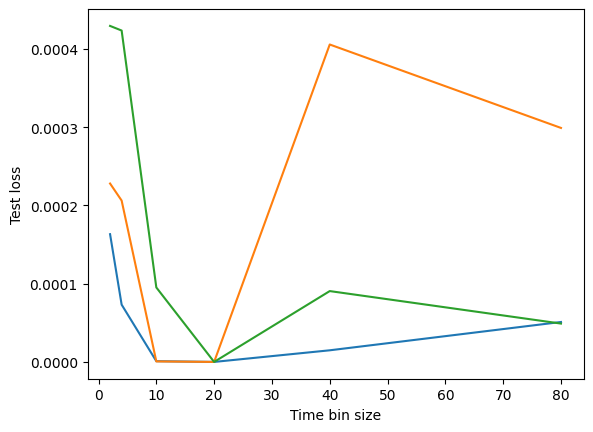

In [6]:
downsample_factor_list = np.array([1, 2, 5, 10, 20, 40])
plt.plot(downsample_factor_list*2, results_simulated[:, 0, :].mean(axis=1)-np.min(results_simulated[:, 0, :].mean(axis=1)))
plt.plot(downsample_factor_list*2, results_simulated[:, 1, :].mean(axis=1)-np.min(results_simulated[:, 1, :].mean(axis=1)))
plt.plot(downsample_factor_list*2, results_real[:, 2, :].mean(axis=1)-np.min(results_real[:, 2, :].mean(axis=1)))
plt.xlabel('Time bin size')
plt.ylabel('Test loss')
plt.show()

In [9]:
# Create a table showing mean and std of results across different time bin sizes
downsample_factor_list = np.array([1, 2, 5, 10, 20, 40])
time_bin_sizes = downsample_factor_list * 2

# Calculate total number of bins
# total_bins = ((len(real_dataloader_fast.test_batches)-1)*real_dataloader_fast.batch_size + 26)*352*250
total_bins = 148720000

# Calculate means multiplied by total_bins and subtract minimum
sim_means_1 = results_simulated[:, 0, :].mean(axis=1) * total_bins
sim_means_1 = sim_means_1 - np.min(sim_means_1)
sim_means_2 = results_simulated[:, 1, :].mean(axis=1) * total_bins 
sim_means_2 = sim_means_2 - np.min(sim_means_2)
real_means = results_real[:, 2, :].mean(axis=1) * total_bins
real_means = real_means - np.min(real_means)

# Create pandas DataFrame
import pandas as pd

results_table = pd.DataFrame({
    'Time Bin Size (ms)': time_bin_sizes,
    'Simulated Data 1': [f'{m:.2e}' for m in sim_means_1],
    'Simulated Data 2': [f'{m:.2e}' for m in sim_means_2], 
    'Real Data': [f'{m:.2e}' for m in real_means]
})

# Display the table
display(results_table)


,Time Bin Size (ms),Simulated Data 1,Simulated Data 2,Real Data
0,2,2.43e+04,3.39e+04,6.39e+04
1,4,1.09e+04,3.07e+04,6.30e+04
2,10,1.43e+02,9.56e+01,1.42e+04
3,20,0.00e+00,0.00e+00,0.00e+00
4,40,2.21e+03,6.03e+04,1.35e+04
5,80,7.59e+03,4.45e+04,7.29e+03
